In [1]:
import warnings
import os
import pickle
import torch

import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq

from plotting import get_pred_perf_variability
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import seaborn as sns
from scipy import stats
from locale import normalize
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score, homogeneity_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")
seed = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
df_gene_var = pd.read_csv("../../output/performance_uncertainty/seqfish.csv", index_col=0)
better_genes = df_gene_var.query(f'perf_var < {np.quantile(df_gene_var.perf_var, 0.5)}').gene.values

In [3]:
pre_datapath = "../../output/preprocessed_dataset/seqFISH_single_cell.pkl"
output_root = "../../output/"

with open(pre_datapath, 'rb') as infile:
    spa_adata, scrna_adata, raw_spatial_df, raw_scrna_df, raw_shared_gene = pickle.load(infile)

df_spa = pd.DataFrame(spa_adata.X.toarray(), columns=spa_adata.var_names)
eval_res_T = {'pred_corr':{}}
eval_res = {'pred_corr':{}}

for file in os.listdir(output_root):
    if file.split('_')[-1].split('.')[0] not in {'spaGE', 'TransImpLR', 'stPlus', 'Tangram', 'TransImpCls'}: continue
    if len(file.split(".")[0].split('_')) != 3: continue    
    spa, rna, method = file.split(".")[0].split('_')
    if spa.lower() != 'seqfish': continue
    df_res = pd.read_csv(os.path.join(output_root,file), index_col=0)
    
    corrs = calc_corr(df_spa, df_res, df_res.columns, False, True)
    corrs_T = calc_corr(df_spa.T, df_res.T, df_res.index, False, True)
    if method == "TransImpLR":
        better_corrs_T = calc_corr(df_spa[better_genes].T, df_res[better_genes].T, df_res.index, False, True)
    
    eval_res_T['pred_corr'][method] = pd.Series(corrs_T)
    eval_res['pred_corr'][method] = pd.Series(corrs, df_res.columns)
    
    if method == "TransImpLR":
        eval_res_T['pred_corr']['TransImp(Top50%)'] = pd.Series(better_corrs_T)
        

In [4]:
df_corr_T      = pd.DataFrame(dict(sorted(eval_res_T['pred_corr'].items())))
df_corr = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_corr['TransImp(Top50%)'] = np.nan
df_corr.loc[better_genes, 'TransImp(Top50%)'] = df_corr.loc[better_genes, 'TransImpLR']

In [5]:
pair_sig_tests = []
for method in df_corr.columns:
    if method.startswith('TransImp'): continue
    _record = {'compairison': f'TransImpLR-{method}'}
    tval, pval = stats.ttest_rel(df_corr['TransImpLR'], df_corr[method])
    _record['tstats'] = tval
    _record['ttpval'] = pval
    wstat, pval = stats.wilcoxon(df_corr['TransImpLR'], df_corr[method])
    _record['wstats'] = wstat
    _record['wcpval'] = pval
    pair_sig_tests.append(_record)

pd.DataFrame(pair_sig_tests)            

,compairison,tstats,ttpval,wstats,wcpval
0,TransImpLR-Tangram,5.650475,3.319418e-08,16332.0,1.986883e-14
1,TransImpLR-spaGE,23.955782,9.151020e-76,694.0,9.949286e-57
2,TransImpLR-stPlus,18.957011,1.217357e-55,3263.0,8.881602e-48


In [6]:
ind_sig_tests = []
for method in df_corr.columns:
    if method.startswith('TransImp(Top50%)'): continue
    _record = {'compairison': f'TransImp(Top50%)-{method}'}
    ustat, upval = stats.mannwhitneyu( 
                   df_corr.loc[better_genes, 'TransImp(Top50%)'], df_corr[method]
    )
    _record['ustats'] = ustat
    _record['upval'] = upval

    tstat, tpval = stats.ttest_ind(
                df_corr.loc[better_genes, 'TransImp(Top50%)'], df_corr[method])
    _record['tstats'] = tstat
    _record['tpval'] = tpval
    ind_sig_tests.append(_record)

pd.DataFrame(ind_sig_tests)

,compairison,ustats,upval,tstats,tpval
0,TransImp(Top50%)-Tangram,41555.0,4.078745e-11,6.853256,2.034213e-11
1,TransImp(Top50%)-TransImpCls,40860.0,6.490416e-10,6.400211,3.447551e-10
2,TransImp(Top50%)-TransImpLR,39607.5,6.112926e-08,5.721624,1.776288e-08
3,TransImp(Top50%)-spaGE,44000.0,5.974558e-16,8.882853,1.042065e-17
4,TransImp(Top50%)-stPlus,42897.0,1.186602e-13,8.132002,3.073518e-15


[Text(0, 0.5, 'Cosine Similarity')]

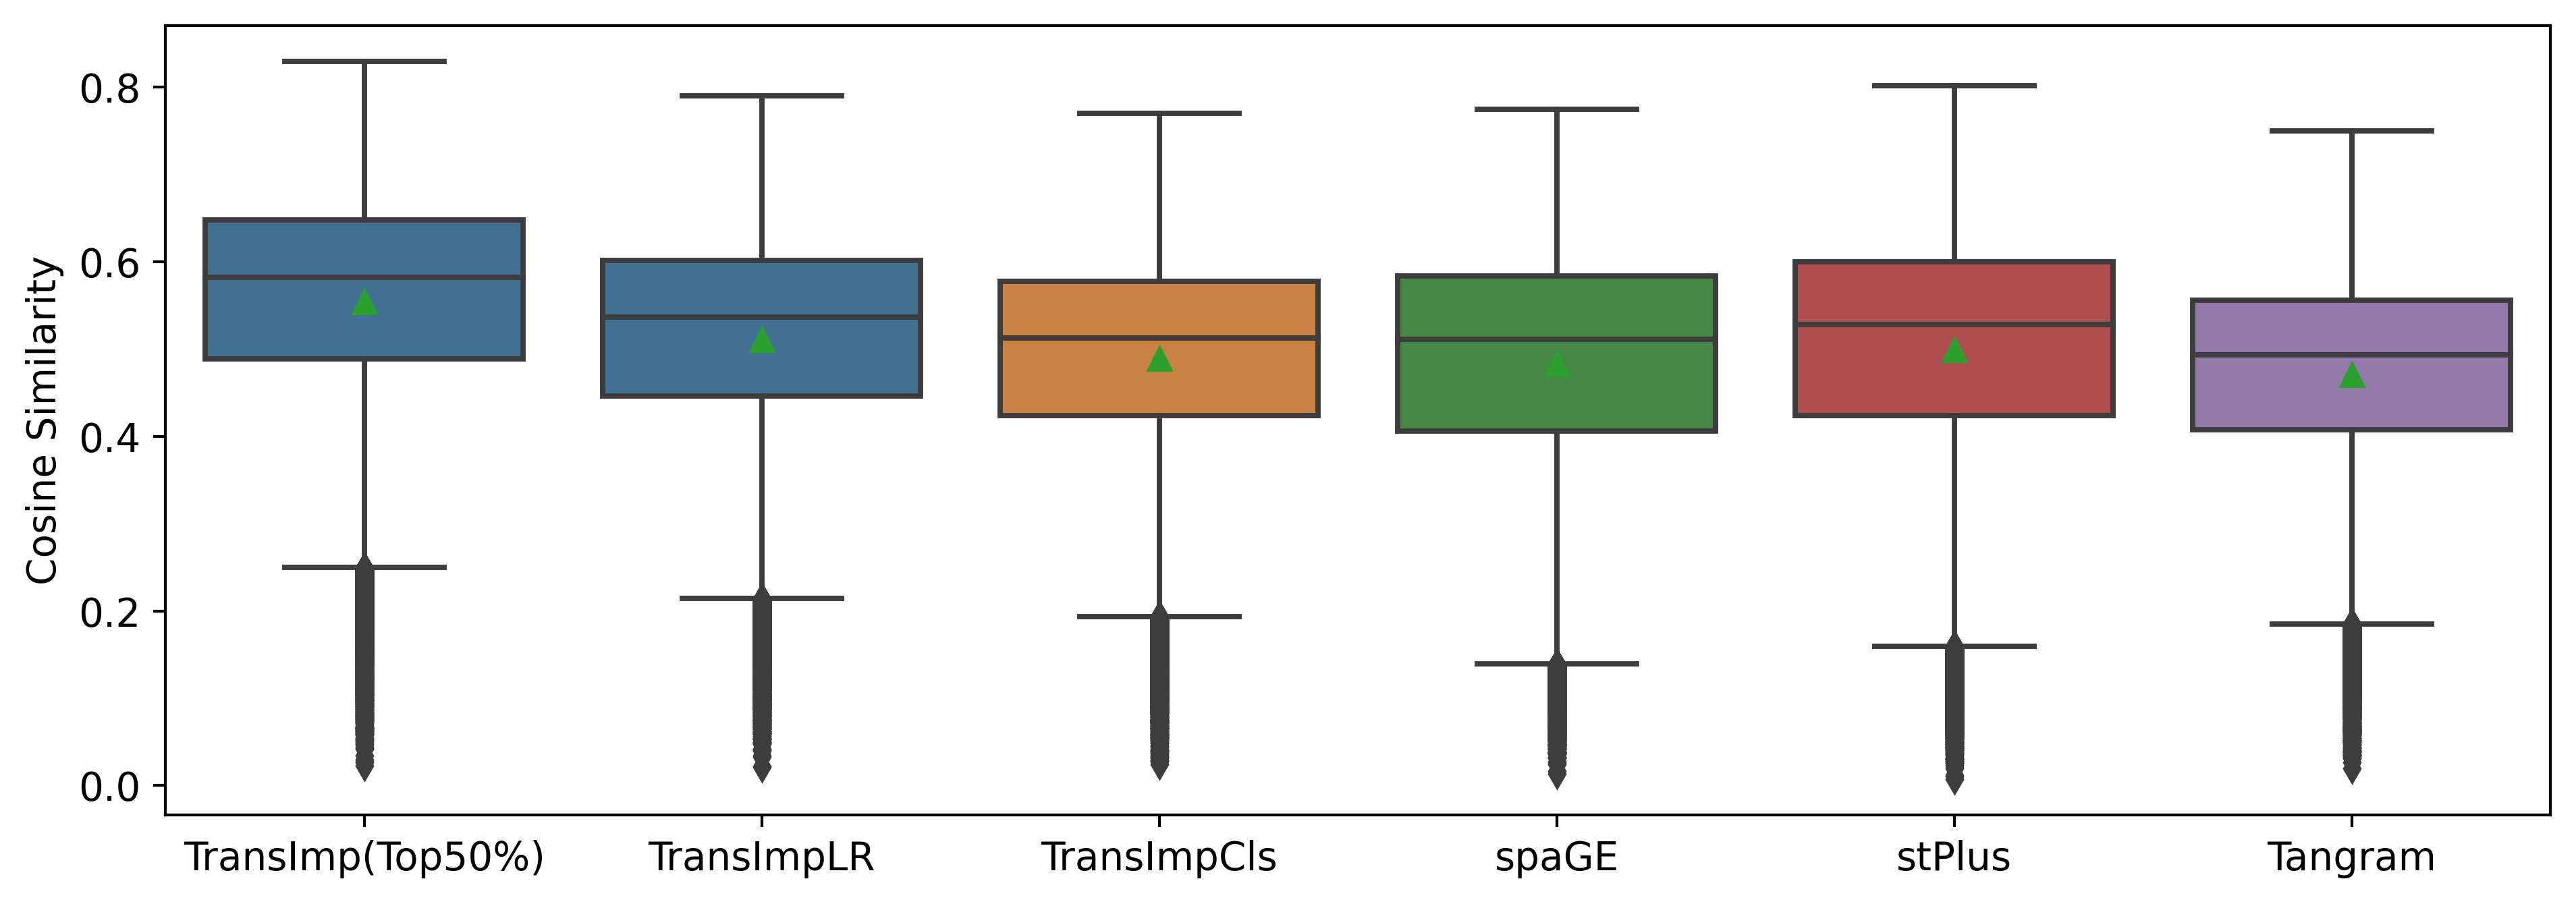

In [7]:
plt.figure(figsize=(12, 4), dpi= 380)
plt.rcParams.update({"font.size":11, 'axes.titlesize':12})
method_order = ["TransImp(Top50%)", "TransImpLR", "TransImpCls", "spaGE", "stPlus", "Tangram"]
color = ['#3274A1', '#3274A1', '#E1812C', '#3A923A', '#C03D3E', '#9372B2', '#845B53', '#D684BD', '#c780e8']
sns.boxplot(data = df_corr_T, showmeans=True, order=method_order[:6], palette=color[:6]).set(
    ylabel="Cosine Similarity"
)